## Interaction with HMix and GMix 


### requirements
- numpy
- torch
- torchvision
- PIL
- matplotlib
- timm 


### Initial settings

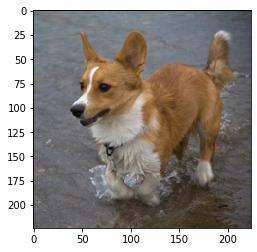

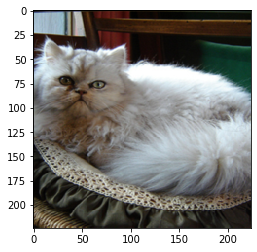

In [47]:
import torch
from PIL import Image
import torchvision
import math

import numpy as np 

import matplotlib.pyplot as plt

%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.show()

image_1 = Image.open("data/picture1.png").convert('RGB')
image_2 = Image.open("data/picture2.png").convert('RGB')

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ToTensor()])

image_1 = transform(image_1)
image_2 = transform(image_2)

# show images 
show(image_1)
show(image_2)


### Visualize Mixup & CutMix 

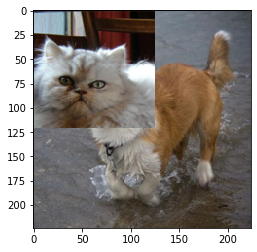

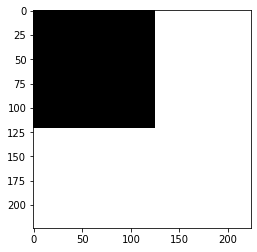

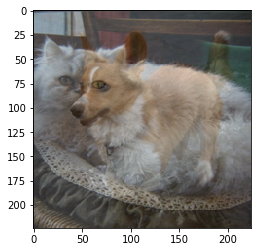

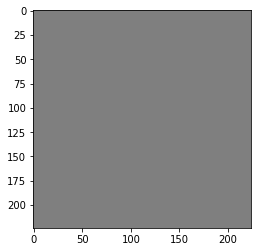

In [104]:
lam = 0.5

from timm.data.mixup import cutmix_bbox_and_lam

# cutmix
(yl, yh, xl, xh), cutmix_lam = cutmix_bbox_and_lam(image_1.shape, lam)
cutmix_mask = torch.ones_like(image_1)
cutmix_mask[:, yl:yh, xl:xh] = 0
cutmix_image = image_1 * cutmix_mask + image_2 * (1. - cutmix_mask)

show(cutmix_image)
show(cutmix_mask)

# mixup
mixup_mask = torch.ones_like(image_1) * lam
mixup_image = image_1 * mixup_mask + image_2 * (1. - mixup_mask)

show(mixup_image)
show(mixup_mask)




### Define HMix and GMix function 
Codes are started from timm mixup code (https://github.com/rwightman/pytorch-image-models/blob/main/timm/data/mixup.py)

In [3]:
def hmix_bbox_and_lam(img_shape, lam, r, margin=0, count=None):
    """ Generate bbox and apply lambda correction.
    """
    ratio = np.sqrt(1 - lam) * np.sqrt(r)
    img_h, img_w = img_shape[-2:]
    cut_h, cut_w = int(img_h * ratio), int(img_w * ratio)
    margin_y, margin_x = int(margin * cut_h), int(margin * cut_w)
    cy = np.random.randint(0 + margin_y, img_h - margin_y, size=count)
    cx = np.random.randint(0 + margin_x, img_w - margin_x, size=count)
    yl = np.clip(cy - cut_h // 2, 0, img_h)
    yu = np.clip(cy + cut_h // 2, 0, img_h)
    xl = np.clip(cx - cut_w // 2, 0, img_w)
    xu = np.clip(cx + cut_w // 2, 0, img_w)

    # yl, yu, xl, xu = rand_bbox(img_shape, lam, count=count)

    bbox_area = (yu - yl) * (xu - xl) 
    # bbox_area = min(bbox_area / r, float(img_shape[-2] * img_shape[-1]))
    lam = 1. - bbox_area / float(img_shape[-2] * img_shape[-1])
    return (yl, yu, xl, xu), lam


def gmix_gaussian_kernel(img_shape, lam):
    """ Generate gmix kernel 
    """
    img_h, img_w = img_shape[-2:]

    # select random center point 
    cy = np.random.randint(0, img_h)
    cx = np.random.randint(0, img_w)

    x_grid = torch.arange(img_h).repeat(img_h, 1) - cx
    y_grid = torch.arange(img_h).repeat(img_h, 1).t() - cy 

    xy_grid = torch.stack([x_grid, y_grid], dim=-1) ** 2.
    dist = torch.sum(xy_grid, dim=-1)
    gaussian_kernel = torch.exp(-dist * math.pi / (lam*img_h*img_h))

    lam_new = gaussian_kernel.sum() / (img_h*img_w)
    return gaussian_kernel, lam_new


### Visualize HMix

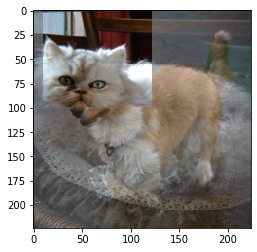

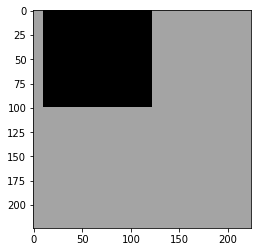

In [76]:
lam = 0.5
hmix_ratio = 0.5

(yl, yh, xl, xh), cutmix_lam = hmix_bbox_and_lam(image_1.shape, lam, hmix_ratio)
mixup_lam = lam / cutmix_lam
lam = mixup_lam * cutmix_lam
# hmix_image = image_1.clone()
# hmix_image.mul_(mixup_lam).add_((1. - mixup_lam) * image_2)
# hmix_image[:, yl:yh, xl:xh] = image_2[:, yl:yh, xl:xh]

hmix_mask = torch.ones_like(image_1) * mixup_lam
hmix_mask[:, yl:yh, xl:xh] = 0

hmix_image = image_1 * hmix_mask + image_2 * (1 - hmix_mask)
show(hmix_image)
show(hmix_mask)

### Visualize GMix

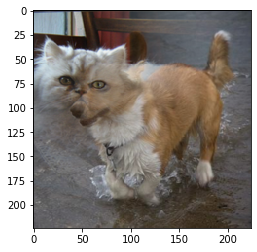

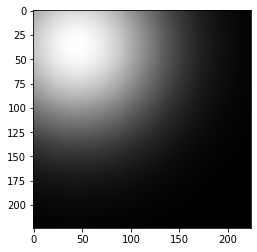

In [61]:
lam = 0.5

gmix_image_1 = image_1.clone()
gmix_image_2 = image_2.clone()

if lam < 0.5:
    gmix_mask, lam_new = gmix_gaussian_kernel(gmix_image_1.shape, lam)
    gmix_image_2 = gmix_image_2 * (1. - gmix_mask)
    gmix_image_1.mul_(gmix_mask).add_(gmix_image_2)
    lam = lam_new
else:
    gmix_mask, lam_new = gmix_gaussian_kernel(gmix_image_1.shape, 1 - lam)
    gmix_image_2 = gmix_image_2.mul_(gmix_mask)
    gmix_image_1.mul_(1. - gmix_mask).add_(gmix_image_2)
    lam = 1. - lam_new

show(gmix_image_1)
show(gmix_mask.tile(3,1,1))